In [17]:
# The imports
import numpy as np
import pandas as pd
import yfinance as yf
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
from sklearn.preprocessing import MinMaxScaler
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [19]:
#Outputting the price table of a certain stock, which is currently Apple
stock = 'AAPL'

stock_data = yf.Ticker(stock)
stock_data = stock_data.history(period="20y")

del stock_data["Dividends"]
stock_data["Tomorrow"] = stock_data["Close"].shift(-1)
stock_data["Target"] = (stock_data["Tomorrow"] > stock_data["Close"]).astype(int)

stock_data

,Open,High,Low,Close,Volume,Stock Splits,Tomorrow,Target
Date,,,,,,,,
2003-10-10 00:00:00-04:00,0.356192,0.360891,0.354221,0.358920,174837600,0.0,0.369075,1
2003-10-13 00:00:00-04:00,0.359678,0.369985,0.359526,0.369075,279865600,0.0,0.372106,1
2003-10-14 00:00:00-04:00,0.368620,0.374986,0.366650,0.372106,275419200,0.0,0.376199,1
2003-10-15 00:00:00-04:00,0.376654,0.379079,0.372561,0.376199,610103200,0.0,0.352402,0
2003-10-16 00:00:00-04:00,0.360739,0.361345,0.339671,0.352402,975682400,0.0,0.344824,0
...,...,...,...,...,...,...,...,...
2023-10-03 00:00:00-04:00,172.259995,173.630005,170.820007,172.399994,49594600,0.0,173.660004,1
2023-10-04 00:00:00-04:00,171.089996,174.210007,170.970001,173.660004,53020300,0.0,174.910004,1
2023-10-05 00:00:00-04:00,173.789993,175.449997,172.679993,174.910004,48527900,0.0,177.490005,1


Text(0.5, 1.0, 'The Stock Price')

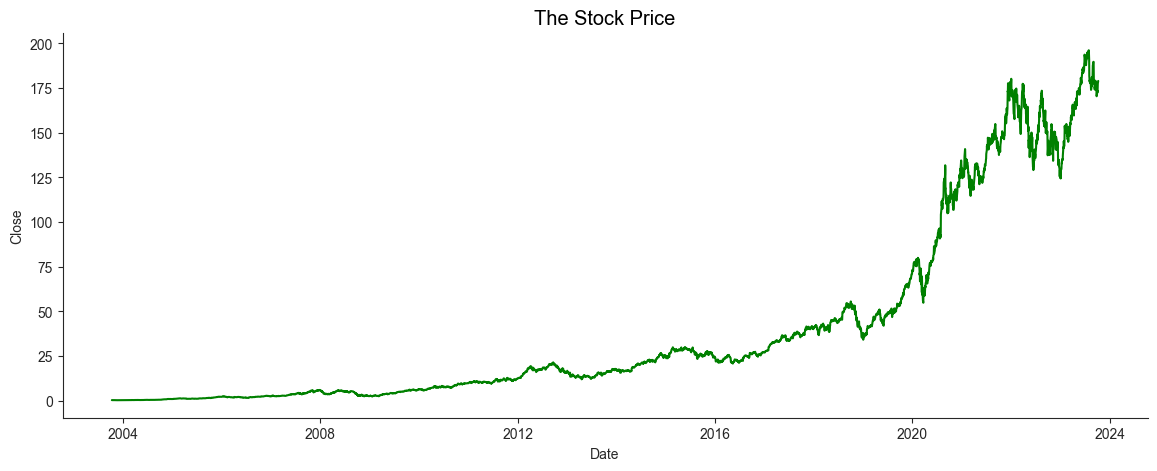

In [20]:
# The below is to plot the stocks over time.
plt.figure(figsize=(14,5))
sns.set_style("ticks")
sns.lineplot(data=stock_data,x="Date",y='Close',color='green')
sns.despine()
plt.title("The Stock Price",size='x-large',color='black')

In [21]:
close_prices = stock_data['Close']
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.95)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))

train_data = scaled_data[0: training_data_len, :]

x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [26]:
test_data = scaled_data[training_data_len-60: , : ]
x_test = []
y_test = values[training_data_len:]

for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [36]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 100)           40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_2 (Dense)             (None, 25)                2525      
                                                                 
 dense_3 (Dense)             (None, 3)                 78        
                                                                 
Total params: 123803 (483.61 KB)
Trainable params: 123803 (483.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 1, epochs=1)

4722/4722 [==============================] - 759s 158ms/step - loss: 5.7048e-04


In [30]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

8/8 [==============================] - 4s 98ms/step


4.94313274246763

C:\Users\kashy\AppData\Local\Temp\ipykernel_80420\3670645671.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


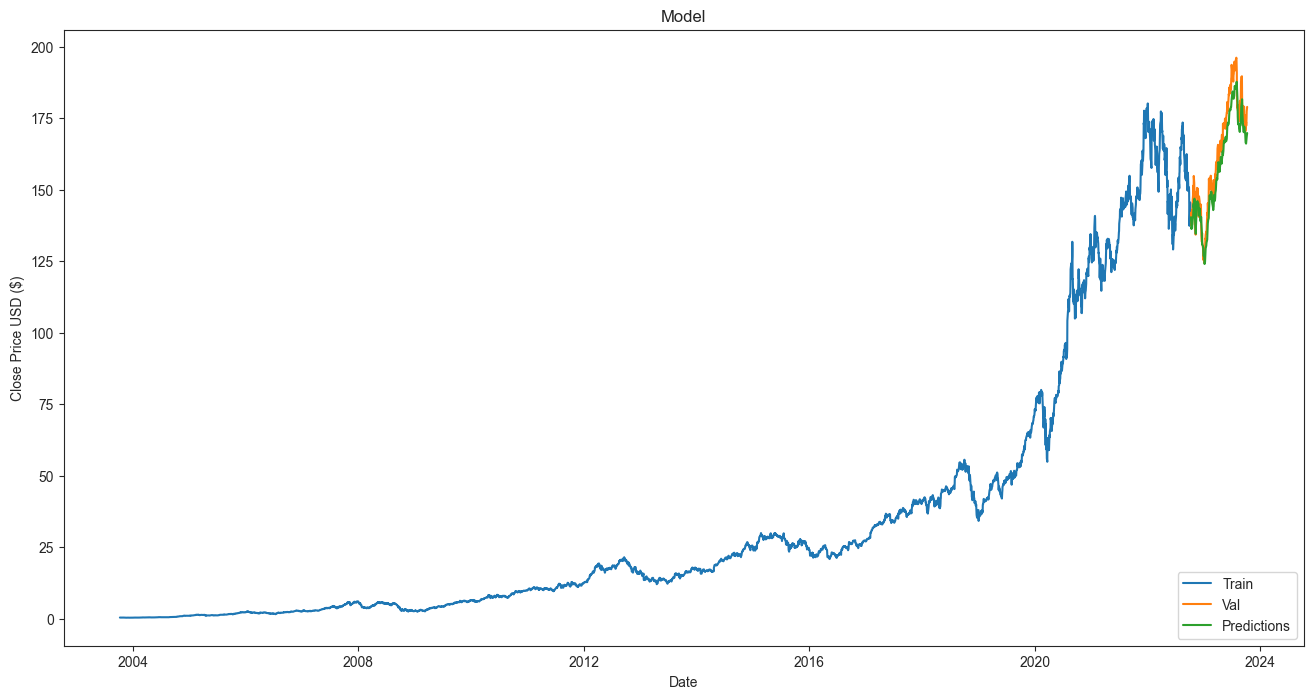

In [37]:
data = stock_data.filter(['Close'])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
test = validation['Close']
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [42]:
count = 0

for index in range(len(predictions)):
    if abs(predictions[index] - test[index]) <= 0.04 * predictions[index]:
        count += 1

print(count / len(predictions))

0.6135458167330677
